# **Time Series Forecasting Tutorial**

by **Tigran Ramazyan & Marko Krsmanovich**

## Imports

In [37]:
import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from statsmodels.tsa import holtwinters
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series

from warnings import simplefilter
simplefilter("ignore", FutureWarning)
%matplotlib inline

**Loading the Box-Jenkins univariate airline dataset.**

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93a2106f50>)

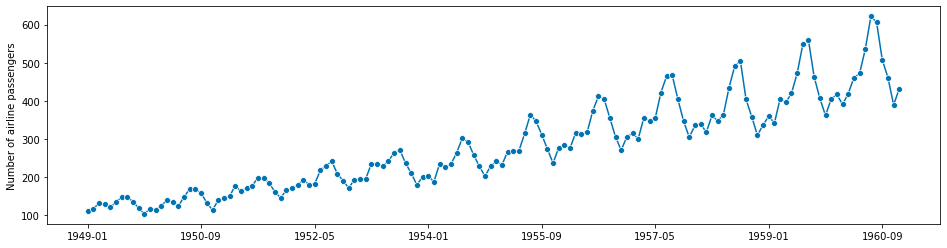

In [5]:
y = load_airline()
plot_series(y)

## Data Preprocessing

**Splitting the data into train and test subsamples**

>Test size is the number of observation which will considered as predicted

>We take it equal to 36, i.e. 36 months.

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f938e4d0190>)

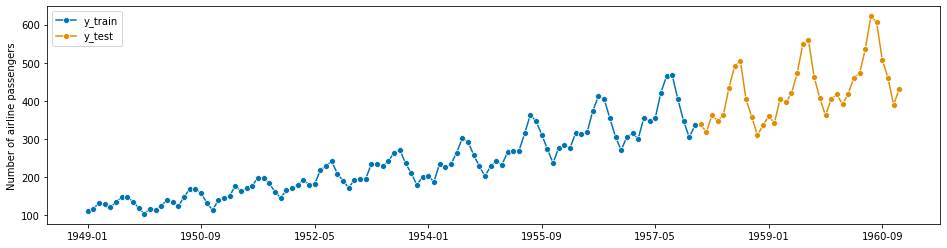

In [6]:
y_train, y_test = temporal_train_test_split(y, test_size=36)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

**We love ETS models, hence we are going to consider them in this tutorial^_^**

**But before we start all the forecasting magic, let's define the forecasting horizon**

In [7]:
horizon = ForecastingHorizon(y_test.index, is_relative=False)
horizon

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', freq='M', is_relative=False)

## ETS Model Tesing
>It is rather obvious that behavior passangers number can be deterministic, since a lot of factors affect it and influence. Such factors as weather, economic environment and mood of exactly person who buy ticket can be stricly determined so the resulting number of passangers too.

## ETS(AAA)

$$y_t = l_{t-1} + s_{t-m} + \varepsilon_t \\
l_t = l_{t-1} + b_{t-1} + \alpha \varepsilon_t \\
b_t = b_{t-1} + \beta \varepsilon_t \\
s_t = s_{t-m} + \gamma \varepsilon_t \\
$$

>For the ExponentialSmoothing function 'trend' and 'seosonality' parameters can be set to either "additive" or "multiplicative"

>and the 'season period' stands for the length of a single period.

SMAPE loss for ETS(AAA) is: 0.0503


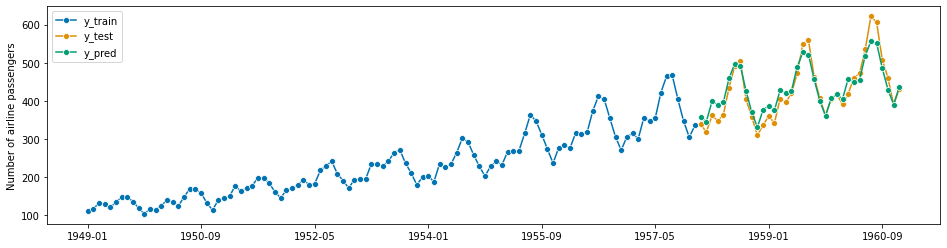

In [39]:
model = ExponentialSmoothing(trend="additive", seasonal="additive", sp=12)

#fit our model on TRAIN set
model.fit(y_train)

#get predictions from fitted model
y_pred = model.predict(horizon)

#plotting predictions
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape = smape_loss(y_test, y_pred)
print(f'SMAPE loss for ETS(AAA) is: {smape:.4f}')

>Unfortunately, the sktime implementation of ETS does not output the estimated hyperparameters. Instead let's use the statsmodels one.

In [41]:
model = holtwinters.ExponentialSmoothing(y_train, trend="additive", seasonal="additive", seasonal_periods=12, initialization_method='estimated')

#fit our model on TRAIN set
model.fit()

#outputting the parameters
model.params

{'damping_trend': nan,
 'initial_level': 118.60768623786116,
 'initial_seasons': array([ -9.09131333,  -3.51780598,   8.96931509,   3.75028312,
         -4.98614868,   9.12754776,  21.33192846,  18.89266652,
          4.71574565, -14.16692412, -28.73682262, -12.30530185]),
 'initial_trend': 2.483900495518276,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.2506316840046855,
 'smoothing_seasonal': 0.7493683159953145,
 'smoothing_trend': 0.0,
 'use_boxcox': False}

>So we get
$$\alpha = 0.2506 \\
\beta = 0 \\
\gamma = 0.7494
$$
or
$$y_t = l_{t-1} + s_{t-m} + \varepsilon_t \\
l_t = l_{t-1} + 0.2506 \cdot \varepsilon_t \\
s_t = s_{t-m} + 0.7494 \cdot \varepsilon_t \\
$$

## AutoETS

**Some times it is hard or inefficent try to guess model parameters.**
**Fortunally we have alghorithm who can automatically diferent model and choose the best one.**
**Let's see what will be the output of AutoETS**


SMAPE loss for AutoETS is: 0.0632


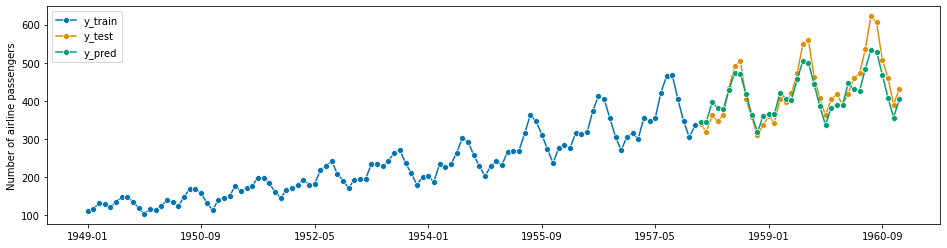

In [50]:
#actually we still need input seosonality size manually
model = AutoETS(auto=True, sp=12, n_jobs=-1)

#fit model
model.fit(y_train)

#obtain predictions
y_pred = model.predict(horizon)

#plotting predictions
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape = smape_loss(y_test, y_pred)
print(f'SMAPE loss for AutoETS is: {smape:.4f}')

## Prediction Intervals

**Unfortunately, ETS models implemented in sktime do not have predictive intervals. But, e.g. ThetaForecaster does have them. Hence**

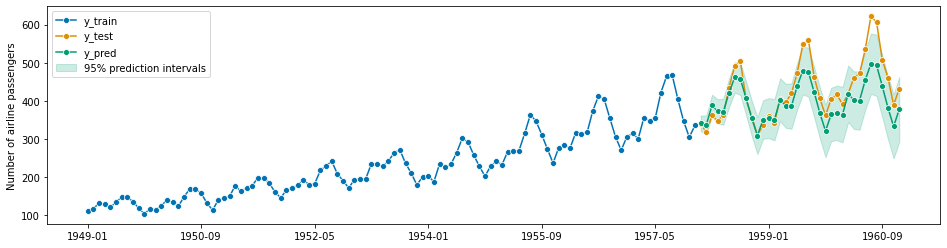

In [45]:
#using ThetaForecaster, which also finds parametrs automatically 
model = ThetaForecaster(sp=12)
#fit our model
model.fit(y_train)

#in alpha we specified alpha for our predicted interval, here it is 5%
y_pred, pred_ints = model.predict(horizon, return_pred_int=True, alpha = 0.05)
smape_loss(y_test, y_pred)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label="95% prediction intervals",
)#fill_between it is a great feature which allow us to draw shaded regions on plots to show intervals
ax.legend();

## Comparison of ETS models

**Now let's compare several ETS models**

>For that we will need a basic forecaster and a parameter grid to go through.

In [54]:
#defining a basic forecaster
forecaster = ExponentialSmoothing(sp=12)

#defining parameters grid
param_grid = {'trend': ["add", "multiplicative"], 
             'seasonal': ["add", "multiplicative"]}

#using sliding window cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
grid_search = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)

#fit grid search
grid_search.fit(y_train)

#grid search predicts using the best over param_grid model
y_pred = grid_search.predict(horizon)

#let's see the results of our grid search
results = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_sMAPE')
results

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


,mean_fit_time,mean_score_time,param_seasonal,param_trend,params,mean_test_sMAPE,rank_test_sMAPE
2,0.099716,0.307681,multiplicative,add,"{'seasonal': 'multiplicative', 'trend': 'add'}",0.070868,1
0,0.094571,0.307794,add,add,"{'seasonal': 'add', 'trend': 'add'}",0.082922,2
3,0.110700,0.310454,multiplicative,multiplicative,"{'seasonal': 'multiplicative', 'trend': 'multi...",0.124517,3
1,0.110281,0.317198,add,multiplicative,"{'seasonal': 'add', 'trend': 'multiplicative'}",0.262825,4


## Best ETS model: ETS(AAM)

$$y_t = (l_{t-1} + b_{t-1}) \cdot s_{t-m} + \varepsilon_t \\
l_t = l_{t-1} + b_{t-1} + \frac{\alpha \varepsilon_t}{s_{t-m}} \\
b_t = b_{t-1} + \frac{\beta \varepsilon_t}{s_{t-m}} \\
s_t = s_{t-m} + \frac{\gamma \varepsilon_t}{s_{t-m}} \\
$$

>Let's find the coefficients using statsmodel

In [56]:
model = holtwinters.ExponentialSmoothing(y_train, trend="additive", seasonal="multiplicative", seasonal_periods=12, initialization_method='estimated')

#fit our model on TRAIN set
model.fit()

#outputting the parameters
model.params

{'damping_trend': nan,
 'initial_level': 66.09420844550955,
 'initial_seasons': array([1.66301788, 1.61426639, 1.8601382 , 1.79915116, 1.79577543,
        2.04934821, 2.25812241, 2.22035842, 1.93965286, 1.67719931,
        1.45945727, 1.63658003]),
 'initial_trend': 1.2533405332219765,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9999999850988388,
 'smoothing_seasonal': 7.613475442010681e-09,
 'smoothing_trend': 0.0,
 'use_boxcox': False}

>So we get
$$\alpha = 0.999999985 \approx 1 \\
\beta = 0 \\
\gamma = 7.6135e^{-9} \approx 0
$$

SMAPE loss for ETS(AAM) is: 0.0514


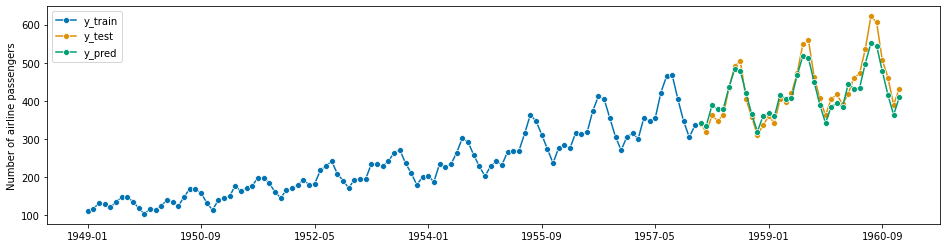

In [55]:
#plotting predictions
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape = smape_loss(y_test, y_pred)
print(f'SMAPE loss for ETS(AAM) is: {smape:.4f}')

**And coupe de grâce: meme**

<img src="meme.png">